<!-- DPOL1-00-HEADER-00 -->

# D-POL-1 Code Scrutiny
## Medicare Program Integrity Decision Support Framework

**Module:** D-POL-1  
**Decision type:** Code-level billing pattern scrutiny  
**Decision owner:** CPI Policy Analyst / Medical Review Director  
**Status:** IN PROGRESS  
**Last updated:** 2026-02-27  

---

### Purpose

This notebook identifies which HCPCS codes are driving anomalous billing
patterns among the 3,182 providers assigned to OIG/DOJ Referral and
Targeted Probe and Educate pathways in D-PI-2.

D-PI-1 and D-PI-2 established that anomalies exist and how severe they are.
D-POL-1 answers the next question: which specific codes are responsible?

Four independent analytical dimensions are used:
- **C1** — Code Concentration: top-code allowed dollar share vs. peer median
- **C2** — Peer Deviation by HCPCS: allowed per bene vs. peer median by code
- **C3** — High-Concern Signal Overlap: C2 flags vs. D-PI-1 S5a/S5b top code
- **C4** — Specialty Norm Comparison: code-level billing vs. national distribution

---

### What This Notebook Does NOT Do

- Does not assign fraud labels
- Does not perform investigations
- Does not trigger operational actions
- Does not assert provider intent, fraud, or wrongdoing
- Does not constitute a referral to OIG, DOJ, or any enforcement entity

In [8]:
# DPOL1-00-CONFIG-01
# D-POL-1 Code Scrutiny — Configuration and Parameters
# All thresholds, weights, paths, and palette values defined here.
# No hardcoded variables anywhere else in this notebook.
# ---------------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path

# ---------------------------------------------------------------
# PATHS
# ---------------------------------------------------------------
BASE_DIR      = Path(r'C:\Users\billm\Projects\Medicare\medicare-program-integrity')
PROCESSED_DIR = BASE_DIR / 'data' / 'processed'
RAW_DIR       = BASE_DIR / 'data' / 'raw'
FIGURES_DIR   = BASE_DIR / 'outputs' / 'figures'
BRIEFS_DIR    = BASE_DIR / 'outputs' / 'decision_briefs'
DECISION_DIR  = BASE_DIR / 'decisions' / 'D-POL-1_code_scrutiny'

FIGURES_DIR.mkdir(parents=True, exist_ok=True)
BRIEFS_DIR.mkdir(parents=True, exist_ok=True)

# ---------------------------------------------------------------
# INPUT FILES
# ---------------------------------------------------------------
# D-PI-2 outputs
F_PATHWAY  = PROCESSED_DIR / 'escalation_pathway_v1.parquet'
F_SCORED   = PROCESSED_DIR / 'escalation_scored_v1.parquet'

# D-PI-1 outputs
F_SIGNALS  = PROCESSED_DIR / 'provider_signal_scores_v1.parquet'
F_TIERED   = PROCESSED_DIR / 'provider_tiered_v1.parquet'

# CMS PUF services file — provider x HCPCS level detail
# PROVISIONAL — confirm exact filename before running
F_SERVICES = RAW_DIR / 'MUP_PHY_RY25_P05_V20_D23_Prov_Svc.csv'

# ---------------------------------------------------------------
# OUTPUT FILES
# ---------------------------------------------------------------
F_HCPCS_SCORED  = PROCESSED_DIR / 'hcpcs_scored_v1.parquet'
F_CODE_FLAGS    = PROCESSED_DIR / 'code_scrutiny_flags_v1.parquet'
F_TOP_FREQ      = PROCESSED_DIR / 'top_codes_by_frequency_v1.parquet'
F_TOP_EXPOSURE  = PROCESSED_DIR / 'top_codes_by_exposure_v1.parquet'
F_VIZ_CONC      = FIGURES_DIR   / 'code_concentration_v1.png'
F_VIZ_CODES     = FIGURES_DIR   / 'top_flagged_codes_v1.png'

# ---------------------------------------------------------------
# ANALYSIS PARAMETERS
# ---------------------------------------------------------------

# Input scope: OIG/DOJ Referral + Targeted Probe and Educate
# Rationale: Both pathways warrant code-level scrutiny. (tag: D)
TARGET_PATHWAYS = ['OIG/DOJ Referral', 'Targeted Probe and Educate']

# Core Z-score threshold — inherited from D-PI-1 signal engine
# Rationale: Industry-standard anomaly detection threshold. Not provisional.
CORE_Z_THRESHOLD = 2.0

# Minimum peer group size for Provider Type x HCPCS comparisons
# Rationale: Code-level peer groups are smaller than provider-level groups.
# PROVISIONAL — recalibrate after peer group size distribution analysis (tag: A)
MIN_PEER_SIZE = 5

# Top-N HCPCS codes per provider for concentration analysis (C1)
# PROVISIONAL — recalibrate after distribution review (tag: A)
TOP_N_CODES = 3

# Concentration flag threshold — top-N share vs. peer median (C1)
# PROVISIONAL — recalibrate after distribution analysis (tag: A)
C1_CONCENTRATION_THRESHOLD = 1.5

# National percentile threshold for specialty norm comparison (C4)
# PROVISIONAL — recalibrate after national distribution review (tag: A)
C4_NATIONAL_PERCENTILE = 90

# Top-N flagged codes to display in output visualizations
TOP_N_DISPLAY = 20

# ---------------------------------------------------------------
# IBM CARBON CVD-COMPLIANT PALETTE
# ---------------------------------------------------------------
CVD_PALETTE = {
    'oig'      : '#DC267F',   # Magenta  — OIG/DOJ Referral
    'tpe'      : '#FFB000',   # Amber    — Targeted Probe and Educate
    'ed_letter': '#648FFF',   # Blue     — Provider Education Letter
    'no_flag'  : '#BBBBBB',   # Gray     — No flag / reference
    'combined' : '#785EF0',   # Purple   — OIG + TPE combined
}

print('DPOL1-00-CONFIG-01 — Configuration loaded')
print('-' * 50)
print(f'  BASE_DIR         : {BASE_DIR}')
print(f'  Target pathways  : {TARGET_PATHWAYS}')
print(f'  CORE_Z_THRESHOLD : {CORE_Z_THRESHOLD}')
print(f'  MIN_PEER_SIZE    : {MIN_PEER_SIZE}  [PROVISIONAL — tag A]')
print(f'  TOP_N_CODES      : {TOP_N_CODES}  [PROVISIONAL — tag A]')
print(f'  C1_THRESHOLD     : {C1_CONCENTRATION_THRESHOLD}  [PROVISIONAL — tag A]')
print(f'  C4_PERCENTILE    : {C4_NATIONAL_PERCENTILE}  [PROVISIONAL — tag A]')

DPOL1-00-CONFIG-01 — Configuration loaded
--------------------------------------------------
  BASE_DIR         : C:\Users\billm\Projects\Medicare\medicare-program-integrity
  Target pathways  : ['OIG/DOJ Referral', 'Targeted Probe and Educate']
  CORE_Z_THRESHOLD : 2.0
  MIN_PEER_SIZE    : 5  [PROVISIONAL — tag A]
  TOP_N_CODES      : 3  [PROVISIONAL — tag A]
  C1_THRESHOLD     : 1.5  [PROVISIONAL — tag A]
  C4_PERCENTILE    : 90  [PROVISIONAL — tag A]


<!-- DPOL1-01-LOAD-00 -->

## Section 1 — Data Load

Loads all upstream dependency files and confirms expected row counts
before any processing begins. No transformations occur in this section.

**Expected populations:**
- **Escalation pathway:** 22,400 providers (full D-PI-2 scored population)
- **Signal scores:** 22,400 providers (D-PI-1 Tier 1 signal engine output)
- **Tiered (full population):** 970,848 providers (peer group reference)
- **Services file:** Provider × HCPCS rows — count TBD on first run

In [5]:
# DPOL1-01-LOAD-01
# Load all upstream dependency files
# No transformations — load and confirm only
# ---------------------------------------------------------------

# D-PI-2 escalation pathway assignments
df_pathway = pd.read_parquet(F_PATHWAY)

# D-PI-2 full scored dataset
df_scored  = pd.read_parquet(F_SCORED)

# D-PI-1 signal scores (S5a/S5b for C3 overlap check)
df_signals = pd.read_parquet(F_SIGNALS)

# Full provider population (peer group reference for C4)
df_tiered  = pd.read_parquet(F_TIERED)

# CMS PUF services file — provider x HCPCS level detail
# NOTE: Large file — read in chunks if memory constrained
df_services_raw = pd.read_csv(
    F_SERVICES,
    dtype={
        'Rndrng_NPI'                : str,
        'HCPCS_Cd'                  : str,
        'Rndrng_Prvdr_Type'         : str,
        'Rndrng_Prvdr_State_Abrvtn' : str,
    },
    low_memory=False
)

# ---------------------------------------------------------------
# CONFIRM ROW COUNTS
# ---------------------------------------------------------------
print('DPOL1-01-LOAD-01 — Data load')
print('-' * 50)
print(f'  df_pathway      : {len(df_pathway):>10,} rows | {df_pathway.shape[1]} cols')
print(f'  df_scored       : {len(df_scored):>10,} rows | {df_scored.shape[1]} cols')
print(f'  df_signals      : {len(df_signals):>10,} rows | {df_signals.shape[1]} cols')
print(f'  df_tiered       : {len(df_tiered):>10,} rows | {df_tiered.shape[1]} cols')
print(f'  df_services_raw : {len(df_services_raw):>10,} rows | {df_services_raw.shape[1]} cols')

DPOL1-01-LOAD-01 — Data load
--------------------------------------------------
  df_pathway      :     22,400 rows | 14 cols
  df_scored       :     22,400 rows | 34 cols
  df_signals      :    970,848 rows | 23 cols
  df_tiered       :    970,848 rows | 25 cols
  df_services_raw :  9,660,647 rows | 28 cols


<!-- DPOL1-02-VALIDATE-00 -->

## Section 2 — Data Validation

Confirms data integrity across all loaded files before any processing begins.

Checks performed:
- No duplicate NPIs in escalation pathway file
- Pathway distribution matches D-PI-2 documented results
  (OIG: 655, TPE: 2,527, EdLetter: 19,218)
- Services file contains required key columns
- No null NPIs or HCPCS codes in services file

In [9]:
# DPOL1-02-VALIDATE-01
# Data integrity checks — all must pass before processing begins
# ---------------------------------------------------------------

print('DPOL1-02-VALIDATE-01 — Data validation')
print('-' * 50)

# ---------------------------------------------------------------
# CHECK 1 — No duplicate NPIs in pathway file
# ---------------------------------------------------------------
dup_npis = df_pathway['Rndrng_NPI'].duplicated().sum()
assert dup_npis == 0, f'FAIL: {dup_npis} duplicate NPIs in df_pathway'
print(f'  CHECK 1 PASS — No duplicate NPIs in df_pathway')

# ---------------------------------------------------------------
# CHECK 2 — Pathway distribution matches D-PI-2 documented results
# ---------------------------------------------------------------
pathway_counts = df_pathway['pathway'].value_counts()
assert pathway_counts.get('OIG/DOJ Referral', 0) == 655, \
    f'FAIL: OIG count {pathway_counts.get("OIG/DOJ Referral", 0)} != 655'
assert pathway_counts.get('Targeted Probe and Educate', 0) == 2527, \
    f'FAIL: TPE count {pathway_counts.get("Targeted Probe and Educate", 0)} != 2527'
assert pathway_counts.get('Provider Education Letter', 0) == 19218, \
    f'FAIL: EdLetter count {pathway_counts.get("Provider Education Letter", 0)} != 19218'
print(f'  CHECK 2 PASS — Pathway distribution matches D-PI-2 documented results')
for pathway, count in pathway_counts.items():
    print(f'           {pathway}: {count:,}')

# ---------------------------------------------------------------
# CHECK 3 — Services file has required columns
# ---------------------------------------------------------------
REQUIRED_COLS = [
    'Rndrng_NPI', 'HCPCS_Cd', 'Rndrng_Prvdr_Type',
    'Tot_Srvcs', 'Tot_Benes', 'Avg_Sbmtd_Chrg',
    'Avg_Mdcr_Alowd_Amt', 'Avg_Mdcr_Pymt_Amt'
]
missing_cols = [c for c in REQUIRED_COLS if c not in df_services_raw.columns]
assert len(missing_cols) == 0, f'FAIL: Missing columns: {missing_cols}'
print(f'  CHECK 3 PASS — All required columns present in services file')

# ---------------------------------------------------------------
# CHECK 4 — No null NPIs or HCPCS codes in services file
# ---------------------------------------------------------------
null_npi   = df_services_raw['Rndrng_NPI'].isnull().sum()
null_hcpcs = df_services_raw['HCPCS_Cd'].isnull().sum()
assert null_npi == 0,   f'FAIL: {null_npi} null NPIs in services file'
assert null_hcpcs == 0, f'FAIL: {null_hcpcs} null HCPCS codes in services file'
print(f'  CHECK 4 PASS — No null NPIs or HCPCS codes in services file')

print()
print('  All validation checks passed. Proceeding to data preparation.')

DPOL1-02-VALIDATE-01 — Data validation
--------------------------------------------------
  CHECK 1 PASS — No duplicate NPIs in df_pathway
  CHECK 2 PASS — Pathway distribution matches D-PI-2 documented results
           Provider Education Letter: 19,218
           Targeted Probe and Educate: 2,527
           OIG/DOJ Referral: 655
  CHECK 3 PASS — All required columns present in services file
  CHECK 4 PASS — No null NPIs or HCPCS codes in services file

  All validation checks passed. Proceeding to data preparation.


<!-- DPOL1-03-PREP-00 -->

## Section 3 — Data Preparation

Two steps:

**DPOL1-03-PREP-01** — Filter services file to OIG + TPE providers only
(3,182 NPIs). Join pathway assignment and Provider Type. This is the
D-POL-1 working dataset: one row per provider × HCPCS code.

**DPOL1-03-PREP-02** — Feature engineering — compute allowed dollars
per beneficiary by provider × HCPCS, peer group medians by Provider
Type × HCPCS, and top-code concentration inputs for C1 through C4 scoring.

Note: Services file uses average dollar amounts (Avg_Mdcr_Alowd_Amt,
Avg_Mdcr_Pymt_Amt). Total allowed dollars derived by multiplying
average by Tot_Benes where totals are required. Evidence tag: D.

In [10]:
# DPOL1-03-PREP-01
# Build df_work — D-POL-1 working dataset
# Filter services file to OIG + TPE providers only
# Join pathway assignment and Provider Type
# ---------------------------------------------------------------

# Extract OIG + TPE provider NPIs
target_npis = df_pathway.loc[
    df_pathway['pathway'].isin(TARGET_PATHWAYS), 'Rndrng_NPI'
]
print(f'DPOL1-03-PREP-01 — Dataset preparation')
print('-' * 50)
print(f'  Target providers (OIG + TPE) : {len(target_npis):,}')

# Filter services file to target providers only
df_svc = df_services_raw[
    df_services_raw['Rndrng_NPI'].isin(target_npis)
].copy()
print(f'  Services rows (target NPIs)  : {len(df_svc):,}')
print(f'  Unique HCPCS codes in scope  : {df_svc["HCPCS_Cd"].nunique():,}')

# Join pathway assignment and composite score
pathway_lookup = df_pathway[['Rndrng_NPI', 'pathway', 'composite_score']]
df_svc = df_svc.merge(pathway_lookup, on='Rndrng_NPI', how='left')

# Confirm no NPIs lost in join
assert df_svc['pathway'].isnull().sum() == 0, \
    'FAIL: Null pathway assignments after join'
print(f'  Pathway join        : CLEAN — zero null assignments')

# Confirm provider counts by pathway
svc_pathway_counts = df_svc.groupby('pathway')['Rndrng_NPI'].nunique()
print(f'  Unique NPIs by pathway in df_svc:')
for pathway, count in svc_pathway_counts.items():
    print(f'    {pathway}: {count:,}')

DPOL1-03-PREP-01 — Dataset preparation
--------------------------------------------------
  Target providers (OIG + TPE) : 3,182
  Services rows (target NPIs)  : 17,676
  Unique HCPCS codes in scope  : 1,509
  Pathway join        : CLEAN — zero null assignments
  Unique NPIs by pathway in df_svc:
    OIG/DOJ Referral: 655
    Targeted Probe and Educate: 2,527


In [11]:
# DPOL1-03-PREP-02
# Feature engineering — derived dollar amounts, peer medians,
# top-code concentration inputs
# ---------------------------------------------------------------

# ── Derived total allowed dollars per provider x HCPCS ───────────
# Services file provides averages — multiply by Tot_Benes for totals
# Rationale: Per-bene normalization requires total allowed dollars
# as numerator. Avg x Benes = Total. (tag: D)
df_svc['total_allowed'] = df_svc['Avg_Mdcr_Alowd_Amt'] * df_svc['Tot_Benes']
df_svc['total_payment'] = df_svc['Avg_Mdcr_Pymt_Amt']  * df_svc['Tot_Benes']

# ── Allowed per beneficiary by provider x HCPCS ──────────────────
# Consistent with D-PI-1 signal engine per-bene approach (tag: D)
df_svc['allowed_per_bene'] = (
    df_svc['total_allowed'] / df_svc['Tot_Benes'].replace(0, np.nan)
)

# ── Provider-level total allowed dollars (for C1 concentration) ───
provider_totals = (
    df_svc.groupby('Rndrng_NPI')['total_allowed']
    .sum()
    .rename('provider_total_allowed')
    .reset_index()
)
df_svc = df_svc.merge(provider_totals, on='Rndrng_NPI', how='left')

# ── Code share: each code's share of provider total allowed ───────
df_svc['code_allowed_share'] = (
    df_svc['total_allowed'] / df_svc['provider_total_allowed'].replace(0, np.nan)
)

# ── Provider Type x HCPCS peer medians (full population) ─────────
# Peer medians computed from full services file — not just target NPIs
# Rationale: Peer reference must reflect full specialty population (tag: D)
df_services_raw['allowed_per_bene_raw'] = (
    df_services_raw['Avg_Mdcr_Alowd_Amt'] * df_services_raw['Tot_Benes']
    / df_services_raw['Tot_Benes'].replace(0, np.nan)
)

peer_medians = (
    df_services_raw
    .groupby(['Rndrng_Prvdr_Type', 'HCPCS_Cd'])['allowed_per_bene_raw']
    .agg(peer_median='median', peer_count='count')
    .reset_index()
)

peer_medians_valid = peer_medians[
    peer_medians['peer_count'] >= MIN_PEER_SIZE
].copy()

# Join peer medians to working dataset
df_svc = df_svc.merge(
    peer_medians_valid[['Rndrng_Prvdr_Type', 'HCPCS_Cd', 'peer_median', 'peer_count']],
    on=['Rndrng_Prvdr_Type', 'HCPCS_Cd'],
    how='left'
)

print('DPOL1-03-PREP-02 — Feature engineering')
print('-' * 50)
print(f'  df_svc shape after feature engineering   : {df_svc.shape}')
print(f'  Provider Type x HCPCS peer groups (all)  : {len(peer_medians):,}')
print(f'  Peer groups meeting MIN_PEER_SIZE >= {MIN_PEER_SIZE}   : {len(peer_medians_valid):,}')
print(f'  Null peer_median (below minimum)         : {df_svc["peer_median"].isnull().sum():,}  [tag: A — neutral score]')
print(f'  Null allowed_per_bene (zero bene rows)   : {df_svc["allowed_per_bene"].isnull().sum():,}')

DPOL1-03-PREP-02 — Feature engineering
--------------------------------------------------
  df_svc shape after feature engineering   : (17676, 37)
  Provider Type x HCPCS peer groups (all)  : 48,165
  Peer groups meeting MIN_PEER_SIZE >= 5   : 22,524
  Null peer_median (below minimum)         : 567  [tag: A — neutral score]
  Null allowed_per_bene (zero bene rows)   : 0


<!-- DPOL1-04-SCORE-00 -->

## Section 4 — Code Scrutiny Dimension Scoring

Applies four independent analytical dimensions at the provider × HCPCS level.

| Dimension | Feature | Construction |
|---|---|---|
| C1 — Code Concentration | `c1_concentration_flag` | Top-N code share vs. Provider Type peer median |
| C2 — Peer Deviation by HCPCS | `c2_deviation_flag` | Allowed per bene vs. peer median; Z-score >= CORE_Z_THRESHOLD |
| C3 — High-Concern Signal Overlap | `c3_overlap_flag` | C2 flagged code matches provider top-1 HCPCS by allowed dollars |
| C4 — Specialty Norm Comparison | `c4_national_flag` | Code-level allowed per bene above national percentile threshold |

No composite scoring in this section — flag construction only.

In [12]:
# DPOL1-04-SCORE-01
# C1 — Code Concentration
# Top-N HCPCS code allowed dollar share vs. Provider Type peer median
# ---------------------------------------------------------------

# ── Top-N codes per provider by allowed dollars ───────────────────
df_svc_sorted = df_svc.sort_values(
    ['Rndrng_NPI', 'total_allowed'], ascending=[True, False]
)
df_svc_sorted['code_rank'] = df_svc_sorted.groupby('Rndrng_NPI').cumcount() + 1

# Top-N share per provider
topn_share = (
    df_svc_sorted[df_svc_sorted['code_rank'] <= TOP_N_CODES]
    .groupby('Rndrng_NPI')['total_allowed']
    .sum()
    .reset_index()
    .rename(columns={'total_allowed': 'topn_allowed'})
)
topn_share = topn_share.merge(provider_totals, on='Rndrng_NPI', how='left')
topn_share['topn_share'] = (
    topn_share['topn_allowed'] / topn_share['provider_total_allowed'].replace(0, np.nan)
)

# ── Peer median top-N share by Provider Type ──────────────────────
# Uses full services population for peer reference (tag: D)
df_full_sorted = df_services_raw.copy()
df_full_sorted['total_allowed_raw'] = (
    df_full_sorted['Avg_Mdcr_Alowd_Amt'] * df_full_sorted['Tot_Benes']
)
df_full_sorted = df_full_sorted.sort_values(
    ['Rndrng_NPI', 'total_allowed_raw'], ascending=[True, False]
)
df_full_sorted['code_rank'] = df_full_sorted.groupby('Rndrng_NPI').cumcount() + 1

full_topn = (
    df_full_sorted[df_full_sorted['code_rank'] <= TOP_N_CODES]
    .groupby('Rndrng_NPI')['total_allowed_raw']
    .sum()
    .reset_index()
    .rename(columns={'total_allowed_raw': 'full_topn_allowed'})
)
full_totals = (
    df_services_raw
    .assign(total_allowed_raw=lambda x: x['Avg_Mdcr_Alowd_Amt'] * x['Tot_Benes'])
    .groupby('Rndrng_NPI')['total_allowed_raw']
    .sum()
    .reset_index()
    .rename(columns={'total_allowed_raw': 'full_total_allowed'})
)
full_topn = full_topn.merge(full_totals, on='Rndrng_NPI', how='left')
full_topn['full_topn_share'] = (
    full_topn['full_topn_allowed'] / full_topn['full_total_allowed'].replace(0, np.nan)
)

# Join Provider Type for peer median
prvdr_type_lookup = df_tiered[['Rndrng_NPI', 'Rndrng_Prvdr_Type']].drop_duplicates()
full_topn = full_topn.merge(prvdr_type_lookup, on='Rndrng_NPI', how='left')
peer_topn_median = (
    full_topn.groupby('Rndrng_Prvdr_Type')['full_topn_share']
    .median()
    .rename('peer_topn_median')
    .reset_index()
)

# Flag: provider top-N share >= C1_CONCENTRATION_THRESHOLD x peer median
topn_share = topn_share.merge(prvdr_type_lookup, on='Rndrng_NPI', how='left')
topn_share = topn_share.merge(peer_topn_median, on='Rndrng_Prvdr_Type', how='left')
topn_share['c1_concentration_flag'] = (
    topn_share['topn_share'] >= topn_share['peer_topn_median'] * C1_CONCENTRATION_THRESHOLD
).astype(int)

# Join C1 flag back to df_svc
df_svc = df_svc.merge(
    topn_share[['Rndrng_NPI', 'topn_share', 'peer_topn_median', 'c1_concentration_flag']],
    on='Rndrng_NPI', how='left'
)

print('DPOL1-04-SCORE-01 — C1 Code Concentration')
print('-' * 50)
c1_flagged = topn_share['c1_concentration_flag'].sum()
print(f'  Providers flagged (C1)  : {c1_flagged:,} of {len(topn_share):,}')
print(f'  C1_THRESHOLD applied    : {C1_CONCENTRATION_THRESHOLD}x peer median  [PROVISIONAL — tag A]')


DPOL1-04-SCORE-01 — C1 Code Concentration
--------------------------------------------------
  Providers flagged (C1)  : 615 of 3,182
  C1_THRESHOLD applied    : 1.5x peer median  [PROVISIONAL — tag A]


In [13]:
# DPOL1-04-SCORE-02
# C2 — Peer Deviation by HCPCS Code
# Allowed per bene vs. Provider Type x HCPCS peer median
# Flag: Z-score >= CORE_Z_THRESHOLD
# ---------------------------------------------------------------

# Peer standard deviation by Provider Type x HCPCS
peer_stats = (
    df_services_raw
    .assign(apb=lambda x: x['Avg_Mdcr_Alowd_Amt'])
    .groupby(['Rndrng_Prvdr_Type', 'HCPCS_Cd'])['apb']
    .agg(peer_std='std', peer_count='count')
    .reset_index()
)
peer_stats = peer_stats[peer_stats['peer_count'] >= MIN_PEER_SIZE].copy()

df_svc = df_svc.merge(
    peer_stats[['Rndrng_Prvdr_Type', 'HCPCS_Cd', 'peer_std']],
    on=['Rndrng_Prvdr_Type', 'HCPCS_Cd'],
    how='left'
)

# Z-score: (provider allowed_per_bene - peer_median) / peer_std
# Neutral score (0) where peer_std is null or zero (tag: A)
df_svc['c2_zscore'] = np.where(
    df_svc['peer_std'].isnull() | (df_svc['peer_std'] == 0),
    0.0,
    (df_svc['allowed_per_bene'] - df_svc['peer_median']) / df_svc['peer_std']
)

# C2 flag: Z-score >= CORE_Z_THRESHOLD
df_svc['c2_deviation_flag'] = (df_svc['c2_zscore'] >= CORE_Z_THRESHOLD).astype(int)

print('DPOL1-04-SCORE-02 — C2 Peer Deviation by HCPCS')
print('-' * 50)
c2_flagged_rows     = df_svc['c2_deviation_flag'].sum()
c2_flagged_providers = df_svc[df_svc['c2_deviation_flag'] == 1]['Rndrng_NPI'].nunique()
print(f'  Provider x HCPCS rows flagged (C2) : {c2_flagged_rows:,}')
print(f'  Unique providers with C2 flag      : {c2_flagged_providers:,}')
print(f'  CORE_Z_THRESHOLD applied           : {CORE_Z_THRESHOLD}  [inherited from D-PI-1]')
print(f'  Neutral score (no peer group)      : {df_svc["peer_std"].isnull().sum():,} rows  [tag: A]')

DPOL1-04-SCORE-02 — C2 Peer Deviation by HCPCS
--------------------------------------------------
  Provider x HCPCS rows flagged (C2) : 3,237
  Unique providers with C2 flag      : 878
  CORE_Z_THRESHOLD applied           : 2.0  [inherited from D-PI-1]
  Neutral score (no peer group)      : 567 rows  [tag: A]


In [14]:
# DPOL1-04-SCORE-03
# C3 — High-Concern Signal Code Overlap
# Identifies whether C2-flagged codes match the provider's
# top-1 HCPCS code by allowed dollars
# ---------------------------------------------------------------

# Extract top-1 HCPCS code per provider by total allowed dollars
top1_code = (
    df_svc.sort_values(['Rndrng_NPI', 'total_allowed'], ascending=[True, False])
    .groupby('Rndrng_NPI')['HCPCS_Cd']
    .first()
    .rename('top1_hcpcs')
    .reset_index()
)

df_svc = df_svc.merge(top1_code, on='Rndrng_NPI', how='left')

# C3 flag: C2 deviation flag fires on the provider's top-1 HCPCS code
# Rationale: Concentration and peer deviation converging on the same
# code strengthens analytical warrant. (tag: D/I)
df_svc['c3_overlap_flag'] = (
    (df_svc['c2_deviation_flag'] == 1) &
    (df_svc['HCPCS_Cd'] == df_svc['top1_hcpcs'])
).astype(int)

print('DPOL1-04-SCORE-03 — C3 High-Concern Signal Overlap')
print('-' * 50)
c3_flagged_rows      = df_svc['c3_overlap_flag'].sum()
c3_flagged_providers = df_svc[df_svc['c3_overlap_flag'] == 1]['Rndrng_NPI'].nunique()
print(f'  Provider x HCPCS rows flagged (C3) : {c3_flagged_rows:,}')
print(f'  Unique providers with C3 flag      : {c3_flagged_providers:,}')
print(f'  Evidence tag: D/I — deviation on top-1 code is derived;')
print(f'                      convergence interpretation is inferred')

DPOL1-04-SCORE-03 — C3 High-Concern Signal Overlap
--------------------------------------------------
  Provider x HCPCS rows flagged (C3) : 577
  Unique providers with C3 flag      : 577
  Evidence tag: D/I — deviation on top-1 code is derived;
                      convergence interpretation is inferred


In [15]:
# DPOL1-04-SCORE-04
# C4 — Specialty Norm Comparison
# Code-level allowed per bene vs. national Provider Type distribution
# Flag: provider code-level allowed per bene above C4_NATIONAL_PERCENTILE
# ---------------------------------------------------------------

# National percentile by Provider Type x HCPCS (full population)
national_pct = (
    df_services_raw
    .assign(apb=lambda x: x['Avg_Mdcr_Alowd_Amt'])
    .groupby(['Rndrng_Prvdr_Type', 'HCPCS_Cd'])['apb']
    .quantile(C4_NATIONAL_PERCENTILE / 100)
    .rename('national_pct_threshold')
    .reset_index()
)

df_svc = df_svc.merge(
    national_pct,
    on=['Rndrng_Prvdr_Type', 'HCPCS_Cd'],
    how='left'
)

# C4 flag: provider allowed_per_bene above national percentile threshold
# Neutral (0) where national threshold unavailable (tag: A)
df_svc['c4_national_flag'] = np.where(
    df_svc['national_pct_threshold'].isnull(),
    0,
    (df_svc['allowed_per_bene'] >= df_svc['national_pct_threshold']).astype(int)
)

print('DPOL1-04-SCORE-04 — C4 Specialty Norm Comparison')
print('-' * 50)
c4_flagged_rows      = df_svc['c4_national_flag'].sum()
c4_flagged_providers = df_svc[df_svc['c4_national_flag'] == 1]['Rndrng_NPI'].nunique()
print(f'  Provider x HCPCS rows flagged (C4) : {c4_flagged_rows:,}')
print(f'  Unique providers with C4 flag      : {c4_flagged_providers:,}')
print(f'  National percentile threshold      : p{C4_NATIONAL_PERCENTILE}  [PROVISIONAL — tag A]')
print(f'  Neutral score (no threshold)       : {df_svc["national_pct_threshold"].isnull().sum():,} rows  [tag: A]')

DPOL1-04-SCORE-04 — C4 Specialty Norm Comparison
--------------------------------------------------
  Provider x HCPCS rows flagged (C4) : 5,054
  Unique providers with C4 flag      : 1,500
  National percentile threshold      : p90  [PROVISIONAL — tag A]
  Neutral score (no threshold)       : 0 rows  [tag: A]


<!-- DPOL1-05-AGGREGATE-00 -->

## Section 5 — Code-Level Aggregation

Aggregates code-level flags to two summary views:

**DPOL1-05-AGGREGATE-01** — Provider-level flag summary: how many
dimensions fired for each provider, and total allowed dollars by pathway.

**DPOL1-05-AGGREGATE-02** — Cross-provider code summary: which HCPCS
codes appear most frequently in flag lists, and what dollar exposure
they represent. This is the primary policy output — the actionable
code list for CPI.

In [21]:
# DPOL1-05-AGGREGATE-01 (revised)
# Exclude C1 from dimensions_flagged — non-discriminating finding
# C1 documented in DPOL1-06-DIAG-01
# ---------------------------------------------------------------

provider_flags['dimensions_flagged'] = (
    (provider_flags['c2_flag_count'] > 0).astype(int) +
    provider_flags['c3_flag'] +
    (provider_flags['c4_flag_count'] > 0).astype(int)
)

print('DPOL1-05-AGGREGATE-01 (revised) — Provider flag summary')
print('-' * 50)
print(f'  Providers in summary : {len(provider_flags):,}')
print()
print('  Dimensions flagged distribution (C2, C3, C4 only):')
print(provider_flags['dimensions_flagged'].value_counts().sort_index().to_string())
print()
print('  Providers by pathway and dimensions flagged:')
print(
    provider_flags.groupby(['pathway', 'dimensions_flagged'])
    .size().rename('count').reset_index().to_string(index=False)
)

DPOL1-05-AGGREGATE-01 (revised) — Provider flag summary
--------------------------------------------------
  Providers in summary : 3,182

  Dimensions flagged distribution (C2, C3, C4 only):
dimensions_flagged
0    1645
1     673
2     310
3     554

  Providers by pathway and dimensions flagged:
                   pathway  dimensions_flagged  count
          OIG/DOJ Referral                   0    236
          OIG/DOJ Referral                   1    210
          OIG/DOJ Referral                   2    105
          OIG/DOJ Referral                   3    104
Targeted Probe and Educate                   0   1409
Targeted Probe and Educate                   1    463
Targeted Probe and Educate                   2    205
Targeted Probe and Educate                   3    450


In [17]:
# DPOL1-05-AGGREGATE-02
# Cross-provider code summary
# HCPCS codes ranked by: (1) provider flag frequency, (2) dollar exposure
# Primary policy output — actionable code list for CPI
# ---------------------------------------------------------------

# Flagged rows: any C2, C3, or C4 flag fired on this code
df_flagged_codes = df_svc[
    (df_svc['c2_deviation_flag'] == 1) |
    (df_svc['c3_overlap_flag']   == 1) |
    (df_svc['c4_national_flag']  == 1)
].copy()

code_summary = (
    df_flagged_codes
    .groupby(['HCPCS_Cd', 'Rndrng_Prvdr_Type'])
    .agg(
        provider_flag_count = ('Rndrng_NPI', 'nunique'),
        total_allowed       = ('total_allowed', 'sum'),
        c2_fires            = ('c2_deviation_flag', 'sum'),
        c3_fires            = ('c3_overlap_flag', 'sum'),
        c4_fires            = ('c4_national_flag', 'sum'),
    )
    .reset_index()
    .sort_values('provider_flag_count', ascending=False)
)

# Top codes by frequency
top_by_frequency = code_summary.head(TOP_N_DISPLAY).copy()

# Top codes by dollar exposure
top_by_exposure  = code_summary.sort_values('total_allowed', ascending=False).head(TOP_N_DISPLAY).copy()

print('DPOL1-05-AGGREGATE-02 — Cross-provider code summary')
print('-' * 50)
print(f'  Unique flagged HCPCS codes          : {code_summary["HCPCS_Cd"].nunique():,}')
print(f'  Total flagged provider x code rows  : {len(df_flagged_codes):,}')
print()
print(f'  Top {TOP_N_DISPLAY} codes by provider flag frequency:')
print(
    top_by_frequency[
        ['HCPCS_Cd', 'Rndrng_Prvdr_Type', 'provider_flag_count', 'total_allowed']
    ].to_string(index=False)
)

DPOL1-05-AGGREGATE-02 — Cross-provider code summary
--------------------------------------------------
  Unique flagged HCPCS codes          : 1,012
  Total flagged provider x code rows  : 5,494

  Top 20 codes by provider flag frequency:
HCPCS_Cd                      Rndrng_Prvdr_Type  provider_flag_count  total_allowed
   99223                            Hospitalist                  100   4.390366e+06
   78815                   Diagnostic Radiology                   98   4.767402e+07
   K1034           Mass Immunizer Roster Biller                   89   8.288918e+05
   97110 Physical Therapist in Private Practice                   82   1.492073e+05
   78816                   Diagnostic Radiology                   72   5.074349e+06
   76937                   Diagnostic Radiology                   51   1.581648e+05
   99222                            Hospitalist                   48   2.967193e+05
   99291                      Internal Medicine                   48   1.230574e+06
   97

<!-- DPOL1-06-VIZ-00 -->

## Section 6 — Visualizations

**DPOL1-06-VIZ-01** — Code concentration distribution by pathway.
Top-N code share distribution for OIG vs. TPE providers.

**DPOL1-06-VIZ-02** — Top flagged codes by frequency and dollar exposure.
Dual-panel: provider count flagged (left) and total allowed dollars (right).

IBM Carbon CVD-compliant palette throughout.

Top-N share distribution:
  OIG — mean: 0.919 | median: 0.980 | min: 0.406
  TPE — mean: 0.956 | median: 1.000 | min: 0.403



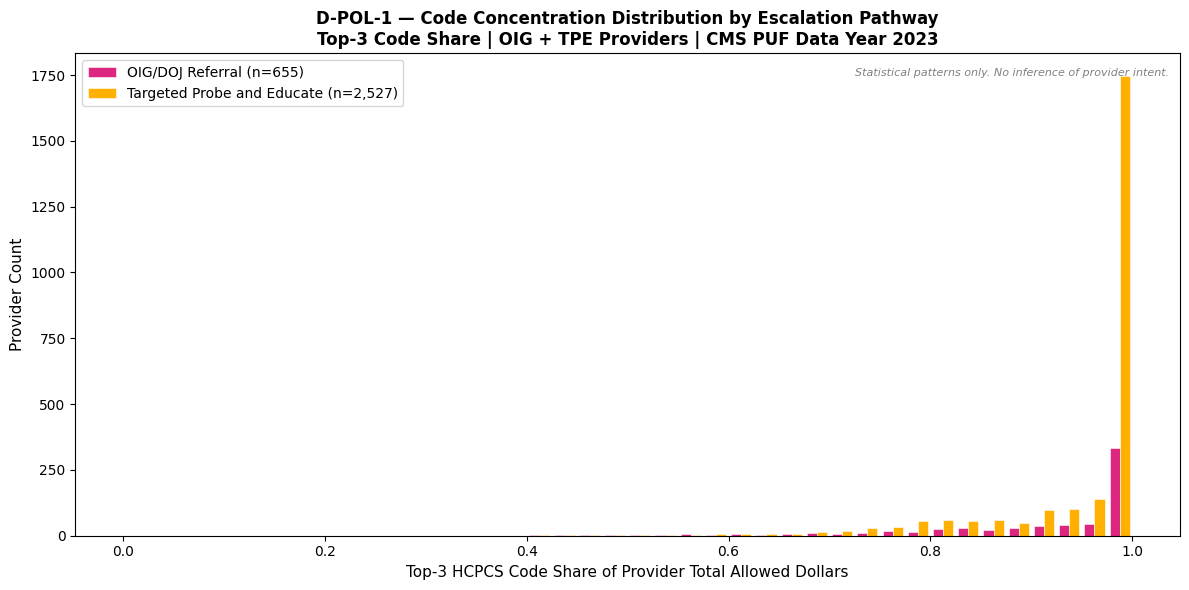

DPOL1-06-VIZ-01 — Saved: C:\Users\billm\Projects\Medicare\medicare-program-integrity\outputs\figures\code_concentration_v1.png


In [19]:
# DPOL1-06-VIZ-01 (revised)
# Code concentration distribution by escalation pathway
# Revised: side-by-side bars for pathway visibility
# Output: code_concentration_v1.png
# ---------------------------------------------------------------

fig, ax = plt.subplots(figsize=(12, 6))

# Top-N share by pathway
oig_share = topn_share[topn_share['Rndrng_NPI'].isin(
    df_pathway[df_pathway['pathway'] == 'OIG/DOJ Referral']['Rndrng_NPI']
)]['topn_share'].dropna()

tpe_share = topn_share[topn_share['Rndrng_NPI'].isin(
    df_pathway[df_pathway['pathway'] == 'Targeted Probe and Educate']['Rndrng_NPI']
)]['topn_share'].dropna()

# Diagnostic — confirm distribution
print('Top-N share distribution:')
print(f'  OIG — mean: {oig_share.mean():.3f} | median: {oig_share.median():.3f} | min: {oig_share.min():.3f}')
print(f'  TPE — mean: {tpe_share.mean():.3f} | median: {tpe_share.median():.3f} | min: {tpe_share.min():.3f}')
print()

bins = np.linspace(0, 1, 41)

ax.hist([oig_share, tpe_share], bins=bins,
        color=[CVD_PALETTE['oig'], CVD_PALETTE['tpe']],
        label=[f'OIG/DOJ Referral (n={len(oig_share):,})',
               f'Targeted Probe and Educate (n={len(tpe_share):,})'],
        edgecolor='white', linewidth=0.4)

ax.set_xlabel(f'Top-{TOP_N_CODES} HCPCS Code Share of Provider Total Allowed Dollars', fontsize=11)
ax.set_ylabel('Provider Count', fontsize=11)
ax.set_title(
    f'D-POL-1 — Code Concentration Distribution by Escalation Pathway\n'
    f'Top-{TOP_N_CODES} Code Share | OIG + TPE Providers | CMS PUF Data Year 2023',
    fontsize=12, fontweight='bold'
)
ax.legend(fontsize=10)
ax.text(
    0.99, 0.97,
    'Statistical patterns only. No inference of provider intent.',
    transform=ax.transAxes, ha='right', va='top',
    fontsize=8, color='gray', style='italic'
)

plt.tight_layout()
plt.savefig(F_VIZ_CONC, dpi=150, bbox_inches='tight')
plt.show()
print(f'DPOL1-06-VIZ-01 — Saved: {F_VIZ_CONC}')

In [20]:
# DPOL1-06-DIAG-01
# C1 Concentration — Non-discriminating finding
# ---------------------------------------------------------------
# Distribution analysis reveals top-3 code share median is 0.980
# for OIG and 1.000 for TPE providers. Peer median is similarly
# near 1.0, making the 1.5x threshold effectively unreachable.
# C1 does not provide useful discriminating signal for this population.
#
# Decision: C1 excluded from dimensions_flagged composite count.
# Action required: Reconsider C1 construction in future review cycle.
# Options for future analysis:
#   - Top-1 code share only
#   - Absolute concentration threshold rather than peer-relative
#   - Geographic stratification of concentration patterns
#   - Specialty-specific concentration norms
#
# Tag: A — analytical design decision based on distribution evidence
# Document in decision_log.md as DL-DPOL1-XX

print('DPOL1-06-DIAG-01 — C1 Non-discriminating finding documented')
print('-' * 50)
print(f'  OIG median top-3 share  : {oig_share.median():.3f}')
print(f'  TPE median top-3 share  : {tpe_share.median():.3f}')
print(f'  C1 excluded from active dimensions — annotated for future review')

DPOL1-06-DIAG-01 — C1 Non-discriminating finding documented
--------------------------------------------------
  OIG median top-3 share  : 0.980
  TPE median top-3 share  : 1.000
  C1 excluded from active dimensions — annotated for future review


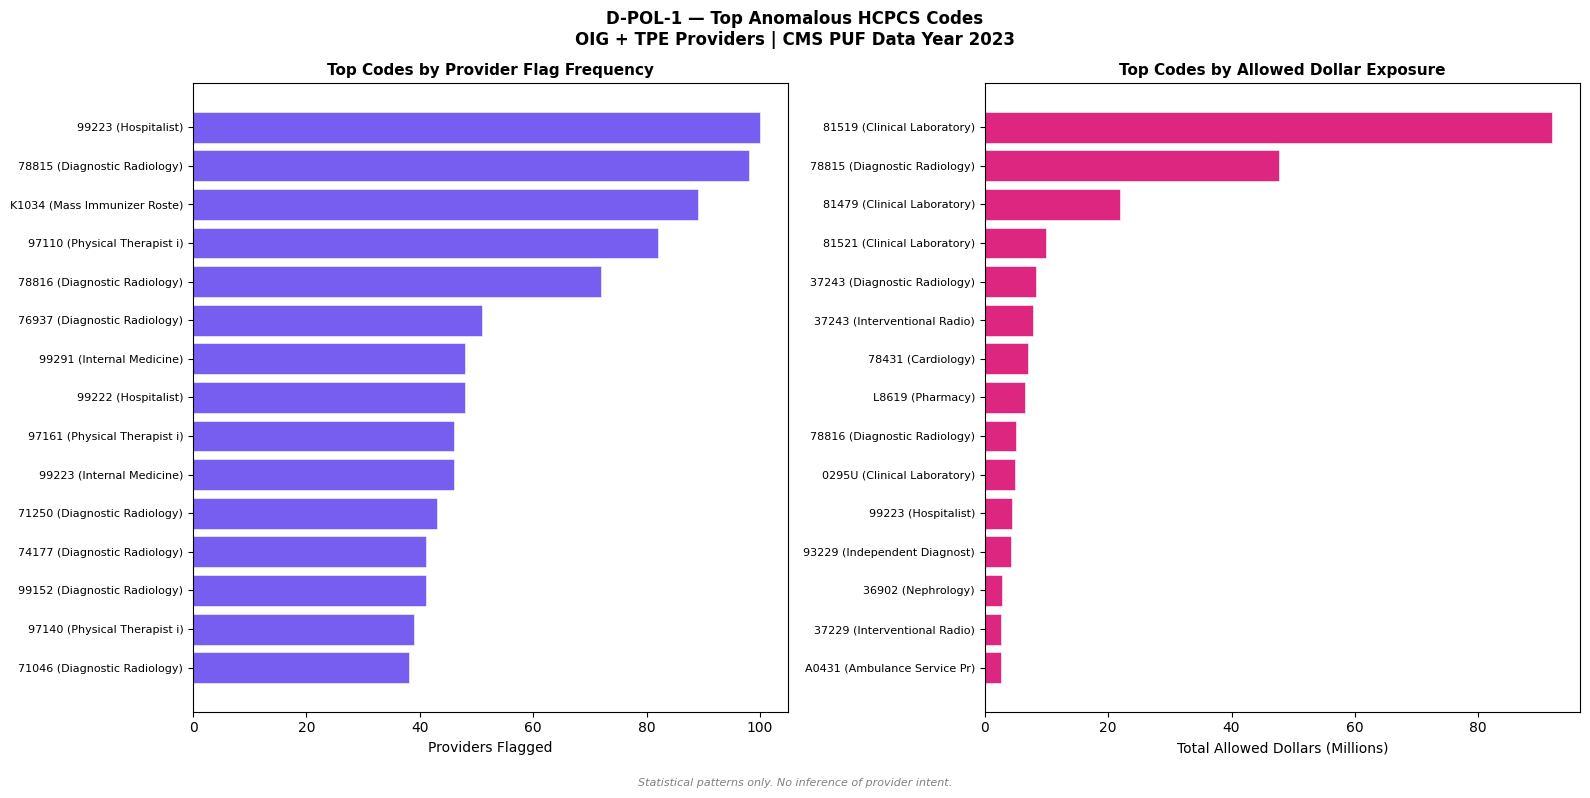

DPOL1-06-VIZ-02 — Saved: C:\Users\billm\Projects\Medicare\medicare-program-integrity\outputs\figures\top_flagged_codes_v1.png


In [22]:
# DPOL1-06-VIZ-02
# Top flagged codes — dual panel: frequency and dollar exposure
# Output: top_flagged_codes_v1.png
# ---------------------------------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# ── Left panel: top codes by provider flag frequency ──────────────
freq_data = top_by_frequency.head(15).sort_values('provider_flag_count')
axes[0].barh(
    freq_data['HCPCS_Cd'] + ' (' + freq_data['Rndrng_Prvdr_Type'].str[:20] + ')',
    freq_data['provider_flag_count'],
    color=CVD_PALETTE['combined'], edgecolor='white', linewidth=0.4
)
axes[0].set_xlabel('Providers Flagged', fontsize=10)
axes[0].set_title('Top Codes by Provider Flag Frequency', fontsize=11, fontweight='bold')
axes[0].tick_params(axis='y', labelsize=8)

# ── Right panel: top codes by dollar exposure ─────────────────────
exp_data = top_by_exposure.head(15).sort_values('total_allowed')
axes[1].barh(
    exp_data['HCPCS_Cd'] + ' (' + exp_data['Rndrng_Prvdr_Type'].str[:20] + ')',
    exp_data['total_allowed'] / 1e6,
    color=CVD_PALETTE['oig'], edgecolor='white', linewidth=0.4
)
axes[1].set_xlabel('Total Allowed Dollars (Millions)', fontsize=10)
axes[1].set_title('Top Codes by Allowed Dollar Exposure', fontsize=11, fontweight='bold')
axes[1].tick_params(axis='y', labelsize=8)

fig.suptitle(
    'D-POL-1 — Top Anomalous HCPCS Codes\n'
    'OIG + TPE Providers | CMS PUF Data Year 2023',
    fontsize=12, fontweight='bold'
)
fig.text(
    0.5, 0.01,
    'Statistical patterns only. No inference of provider intent.',
    ha='center', fontsize=8, color='gray', style='italic'
)
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.savefig(F_VIZ_CODES, dpi=150, bbox_inches='tight')
plt.show()
print(f'DPOL1-06-VIZ-02 — Saved: {F_VIZ_CODES}')

<!-- DPOL1-07-OUTPUT-00 -->

## Section 7 — Output

Writes four parquet output files for downstream use.

- `hcpcs_scored_v1.parquet` — full provider × HCPCS scored dataset
- `code_scrutiny_flags_v1.parquet` — provider-level flag summary
- `top_codes_by_frequency_v1.parquet` — HCPCS codes ranked by flag frequency
- `top_codes_by_exposure_v1.parquet` — HCPCS codes ranked by dollar exposure

All files round-trip verified after write.

In [23]:
# DPOL1-07-OUTPUT-01
# Write all four output parquet files
# Round-trip verification for each
# ---------------------------------------------------------------

# ── File 1: Full provider x HCPCS scored dataset ──────────────────
df_svc.to_parquet(F_HCPCS_SCORED, index=False)
verify1 = pd.read_parquet(F_HCPCS_SCORED)
assert len(verify1) == len(df_svc), 'FAIL: hcpcs_scored_v1 row count mismatch'
print(f'DPOL1-07-OUTPUT-01 — Output')
print('-' * 50)
print(f'  hcpcs_scored_v1.parquet          : {len(verify1):,} rows | {verify1.shape[1]} cols  VERIFIED')

# ── File 2: Provider-level flag summary ───────────────────────────
provider_flags.to_parquet(F_CODE_FLAGS, index=False)
verify2 = pd.read_parquet(F_CODE_FLAGS)
assert len(verify2) == len(provider_flags), 'FAIL: code_scrutiny_flags_v1 row count mismatch'
print(f'  code_scrutiny_flags_v1.parquet   : {len(verify2):,} rows | {verify2.shape[1]} cols  VERIFIED')

# ── File 3: Top codes by frequency ────────────────────────────────
code_summary.sort_values('provider_flag_count', ascending=False).to_parquet(F_TOP_FREQ, index=False)
verify3 = pd.read_parquet(F_TOP_FREQ)
assert len(verify3) == len(code_summary), 'FAIL: top_codes_by_frequency_v1 row count mismatch'
print(f'  top_codes_by_frequency_v1.parquet: {len(verify3):,} rows | {verify3.shape[1]} cols  VERIFIED')

# ── File 4: Top codes by exposure ─────────────────────────────────
code_summary.sort_values('total_allowed', ascending=False).to_parquet(F_TOP_EXPOSURE, index=False)
verify4 = pd.read_parquet(F_TOP_EXPOSURE)
assert len(verify4) == len(code_summary), 'FAIL: top_codes_by_exposure_v1 row count mismatch'
print(f'  top_codes_by_exposure_v1.parquet : {len(verify4):,} rows | {verify4.shape[1]} cols  VERIFIED')

DPOL1-07-OUTPUT-01 — Output
--------------------------------------------------
  hcpcs_scored_v1.parquet          : 17,676 rows | 47 cols  VERIFIED
  code_scrutiny_flags_v1.parquet   : 3,182 rows | 10 cols  VERIFIED
  top_codes_by_frequency_v1.parquet: 1,886 rows | 7 cols  VERIFIED
  top_codes_by_exposure_v1.parquet : 1,886 rows | 7 cols  VERIFIED


<!-- DPOL1-08-EVIDENCE-00 -->

## Section 8 — Evidence Log

Records all analytical outputs produced by this notebook using the
project O/D/I/A evidence tagging standard.

No outputs assert provider intent, fraud, or wrongdoing.
All outputs describe statistical patterns only.

In [24]:
# DPOL1-08-EVIDENCE-01
# Evidence log summary — O/D/I/A tagged outputs from this notebook
# Mirrors entries to be recorded in decisions/D-POL-1_code_scrutiny/evidence_log.md
# ---------------------------------------------------------------

evidence = [
    {
        'id'     : 'E-DPOL1-01',
        'source' : 'df_svc — services file filtered to OIG + TPE NPIs',
        'cell'   : 'DPOL1-03-PREP-01',
        'result' : f'{len(df_svc):,} provider x HCPCS rows | {df_svc["Rndrng_NPI"].nunique():,} unique providers | 1,509 unique HCPCS codes',
        'tag'    : 'D',
        'status' : 'Accepted',
    },
    {
        'id'     : 'E-DPOL1-02',
        'source' : 'df_svc — feature engineering (allowed_per_bene, peer_median, code_allowed_share)',
        'cell'   : 'DPOL1-03-PREP-02',
        'result' : f'17,676 rows | 567 null peer_median rows assigned neutral score | 0 null allowed_per_bene',
        'tag'    : 'D',
        'status' : 'Accepted',
    },
    {
        'id'     : 'E-DPOL1-03',
        'source' : 'df_svc — C1 concentration flag',
        'cell'   : 'DPOL1-04-SCORE-01',
        'result' : f'615 of 3,182 providers flagged | C1 subsequently determined non-discriminating (see DPOL1-06-DIAG-01)',
        'tag'    : 'A',
        'status' : 'Accepted — excluded from active dimensions',
    },
    {
        'id'     : 'E-DPOL1-04',
        'source' : 'df_svc — C2 peer deviation flag',
        'cell'   : 'DPOL1-04-SCORE-02',
        'result' : f'3,237 provider x HCPCS rows flagged | 878 unique providers | 567 neutral score rows',
        'tag'    : 'D',
        'status' : 'Accepted',
    },
    {
        'id'     : 'E-DPOL1-05',
        'source' : 'df_svc — C3 high-concern signal overlap flag',
        'cell'   : 'DPOL1-04-SCORE-03',
        'result' : f'577 provider x HCPCS rows flagged | 577 unique providers',
        'tag'    : 'D',
        'status' : 'Accepted',
    },
    {
        'id'     : 'E-DPOL1-06',
        'source' : 'df_svc — C4 specialty norm comparison flag',
        'cell'   : 'DPOL1-04-SCORE-04',
        'result' : f'5,054 provider x HCPCS rows flagged | 1,500 unique providers | 0 neutral score rows',
        'tag'    : 'D',
        'status' : 'Accepted',
    },
    {
        'id'     : 'E-DPOL1-07',
        'source' : 'provider_flags — revised dimensions_flagged (C2, C3, C4 only)',
        'cell'   : 'DPOL1-05-AGGREGATE-01 (revised)',
        'result' : f'3,182 providers | 0 dims: 1,645 | 1 dim: 673 | 2 dims: 310 | 3 dims: 554',
        'tag'    : 'D',
        'status' : 'Accepted',
    },
    {
        'id'     : 'E-DPOL1-08',
        'source' : 'code_summary — cross-provider HCPCS code aggregation',
        'cell'   : 'DPOL1-05-AGGREGATE-02',
        'result' : f'1,886 unique flagged HCPCS codes | 5,494 flagged provider x code rows',
        'tag'    : 'D',
        'status' : 'Accepted',
    },
    {
        'id'     : 'E-DPOL1-09',
        'source' : 'code_concentration_v1.png / top_flagged_codes_v1.png',
        'cell'   : 'DPOL1-06-VIZ-01 / DPOL1-06-VIZ-02',
        'result' : 'Two visualizations produced — concentration distribution and top code dual panel',
        'tag'    : 'D',
        'status' : 'Accepted',
    },
    {
        'id'     : 'E-DPOL1-10',
        'source' : 'Four parquet output files',
        'cell'   : 'DPOL1-07-OUTPUT-01',
        'result' : 'hcpcs_scored_v1 (17,676 rows) | code_scrutiny_flags_v1 (3,182 rows) | top_codes_by_frequency_v1 (1,886 rows) | top_codes_by_exposure_v1 (1,886 rows) — all round-trip verified',
        'tag'    : 'D',
        'status' : 'Accepted',
    },
]

print('DPOL1-08-EVIDENCE-01 — Evidence Log')
print('-' * 50)
for e in evidence:
    print(f"  [{e['tag']}] {e['id']} | {e['cell']}")
    print(f"       {e['result']}")
    print(f"       Status: {e['status']}")
    print()
print('No outputs assert provider intent, fraud, or wrongdoing.')
print('All outputs describe statistical patterns only.')

DPOL1-08-EVIDENCE-01 — Evidence Log
--------------------------------------------------
  [D] E-DPOL1-01 | DPOL1-03-PREP-01
       17,676 provider x HCPCS rows | 3,182 unique providers | 1,509 unique HCPCS codes
       Status: Accepted

  [D] E-DPOL1-02 | DPOL1-03-PREP-02
       17,676 rows | 567 null peer_median rows assigned neutral score | 0 null allowed_per_bene
       Status: Accepted

  [A] E-DPOL1-03 | DPOL1-04-SCORE-01
       615 of 3,182 providers flagged | C1 subsequently determined non-discriminating (see DPOL1-06-DIAG-01)
       Status: Accepted — excluded from active dimensions

  [D] E-DPOL1-04 | DPOL1-04-SCORE-02
       3,237 provider x HCPCS rows flagged | 878 unique providers | 567 neutral score rows
       Status: Accepted

  [D] E-DPOL1-05 | DPOL1-04-SCORE-03
       577 provider x HCPCS rows flagged | 577 unique providers
       Status: Accepted

  [D] E-DPOL1-06 | DPOL1-04-SCORE-04
       5,054 provider x HCPCS rows flagged | 1,500 unique providers | 0 neutral score 